In [1]:
import os

import numpy as np
import torch

from tqdm import tqdm

In [2]:
info = torch.load("./data/dataset.pt")
info


,pdb,mutation,affinity_wt,affinity_mut,temp,ddg,daffinity
0,1CSE_E_I,LI38G,1.120000e-12,5.260000e-11,294.0,2.248833,5.148000e-11
1,1CSE_E_I,LI38S,1.120000e-12,8.330000e-12,294.0,1.172229,7.210000e-12
2,1CSE_E_I,LI38P,1.120000e-12,1.020000e-07,294.0,6.671276,1.019989e-07
3,1CSE_E_I,LI38I,1.120000e-12,1.720000e-10,294.0,2.940988,1.708800e-10
4,1CSE_E_I,LI38D,1.120000e-12,1.920000e-09,294.0,4.350434,1.918880e-09
...,...,...,...,...,...,...,...
5842,3QIB_ABP_CD,KP8R,5.500000e-06,2.400000e-04,298.0,2.235909,2.345000e-04
5843,3QIB_ABP_CD,TP11A,5.500000e-06,1.100000e-03,298.0,3.137419,1.094500e-03
5844,3QIB_ABP_CD,TP11S,5.500000e-06,3.380000e-05,298.0,1.075181,2.830000e-05
5845,3QIB_ABP_CD,TP11N,5.500000e-06,4.340000e-05,298.0,1.223219,3.790000e-05


In [4]:
from data import *

train_dataset = SiameseProteinGraphDataset(info, feature_path="./data/", radius=15)

index = 3
train_dataset[index]

(Data(edge_index=[2, 21299], name='1CSE', seq='AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGGASFVAGEAYNTDGNGHGTHVAGTVAALDNTTGVLGVAPSVSLYAVKVLNSSGSGSYSGIVSGIEWATTNGMDVINMSLGGASGSTAMKQAVDNAYARGVVVVAAAGNSGNSGSTNTIGYPAKYDSVIAVGAVDSNSNRASFSSVGAELEVMAPGAGVYSTYPTNTYATLNGTSMASPHVAGAAALILSKHPNLSASQVRNRLSSTATYLGSSFYYGKGLINVEAAAQKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLDLRYNRVRVFYNPGTNVVNHVPHVG', coord=[337, 5, 3], node_feat=[337, 1033]),
 Data(edge_index=[2, 21299], name='1CSE_E_I_LI38I', seq='AQTVPYGIPLIKADKVQAQGFKGANVKVAVLDTGIQASHPDLNVVGGASFVAGEAYNTDGNGHGTHVAGTVAALDNTTGVLGVAPSVSLYAVKVLNSSGSGSYSGIVSGIEWATTNGMDVINMSLGGASGSTAMKQAVDNAYARGVVVVAAAGNSGNSGSTNTIGYPAKYDSVIAVGAVDSNSNRASFSSVGAELEVMAPGAGVYSTYPTNTYATLNGTSMASPHVAGAAALILSKHPNLSASQVRNRLSSTATYLGSSFYYGKGLINVEAAAQKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTIDLRYNRVRVFYNPGTNVVNHVPHVG', coord=[337, 5, 3], node_feat=[337, 1033]),
 tensor(2.9410))

In [5]:
from torch_geometric.loader import DataLoader

batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

print(f"train_dataset: {train_dataset.__len__()}")  # total_data * (fold-1)/fold
print(f"train_dataloader: {train_dataloader.__len__()}")  # num_samples / batch_size


train_dataset: 5847
train_dataloader: 1462


In [6]:
using_gpu = True
if using_gpu and torch.cuda.is_available():
    gpu_ids = list(range(torch.cuda.device_count()))
    print(f"Available GPUs: {gpu_ids}")
    device = torch.device("cuda", gpu_ids[3])
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")

Available GPUs: [0, 1, 2, 3, 4, 5, 6]
Using device: cuda:3


In [7]:
from model import *

model = SiameseGPSite().to(device)


In [8]:
learning_rate = 1e-3
beta12 = (0.9, 0.99)
num_epochs = 25
epochs = 25

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=beta12, weight_decay=1e-5, eps=1e-5)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_dataloader), epochs=epochs)  # ???



In [11]:
# test
train_data = next(iter(train_dataloader))
model.eval()
with torch.no_grad():
    wt_graph, mut_graph, y = train_data
    wt_graph, mut_graph, y = wt_graph.to(device), mut_graph.to(device), y.to(device)
    print(wt_graph)
    print(mut_graph)

    pred = model(wt_graph, mut_graph)

    print(f"Predicted: {pred}\nActual: {y}")
    # print((pred == y))
    # print(((pred == y)).sum())
    


DataBatch(edge_index=[2, 85196], name=[4], seq=[4], coord=[1348, 5, 3], node_feat=[1348, 1033], batch=[1348], ptr=[5])
DataBatch(edge_index=[2, 85196], name=[4], seq=[4], coord=[1348, 5, 3], node_feat=[1348, 1033], batch=[1348], ptr=[5])
Predicted: tensor([-0.0351, -0.0351, -0.0349, -0.0349], device='cuda:3')
Actual: tensor([2.2488, 1.1722, 6.6713, 2.9410], device='cuda:3')


In [12]:
# train
loss_history = []
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0, leave=True)

    for batch, (wt_graph, mut_graph, y) in progress_bar:
        wt_graph, mut_graph, y = wt_graph.to(device), mut_graph.to(device), y.to(device)
        pred = model(wt_graph, mut_graph)

        loss = loss_fn(pred, y)
        # print(loss)
        loss_history.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.set_description(f"\033[31mloss: {loss:.4f}\033[0m")


Epoch 1/25


loss: 0.5296:  21%|██        | 303/1462 [08:43<33:23,  1.73s/it]  


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

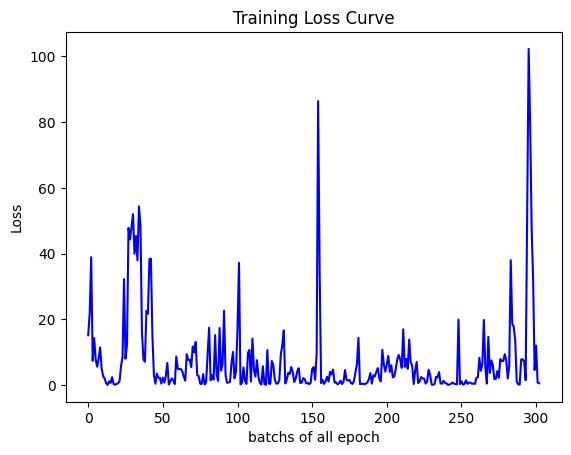

In [18]:
import matplotlib.pyplot as plt


plt.figure()
plt.plot(range(len(loss_history)), loss_history, label='Training Loss', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('batchs of all epoch')
plt.ylabel('Loss')